- Implement the same problem statement using a different pre-trained model. You can have use any of these or whichever other model you like. Alternatively, you can create your own CNN and observe the difference and effectiveness of Transfer Learning.

- Try implementing image augmentation, change the number of epochs, the dense layers and neurons and compare your result with what we have done together in this project.

In [ ]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd
import os

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2

'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''Result and Performance Analysis'''
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")


# Exploratory Analysis

In [2]:
DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes out of the required folders
classes

['Shrimp',
 'Striped Red Mullet',
 'Trout',
 'Sea Bass',
 'Gilt-Head Bream',
 'Red Mullet',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Hourse Mackerel']

In [4]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

import pandas as pd
label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [5]:
df.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp


In [6]:
df.path[0]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00298.png'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [8]:
#Checking the value counts of each of the datasets
#df['label']=df['label'].astype('category')
df['label'].value_counts()

,count
label,
Shrimp,1000
Striped Red Mullet,1000
Trout,1000
Sea Bass,1000
Gilt-Head Bream,1000
Red Mullet,1000
Red Sea Bream,1000
Black Sea Sprat,1000
Hourse Mackerel,1000


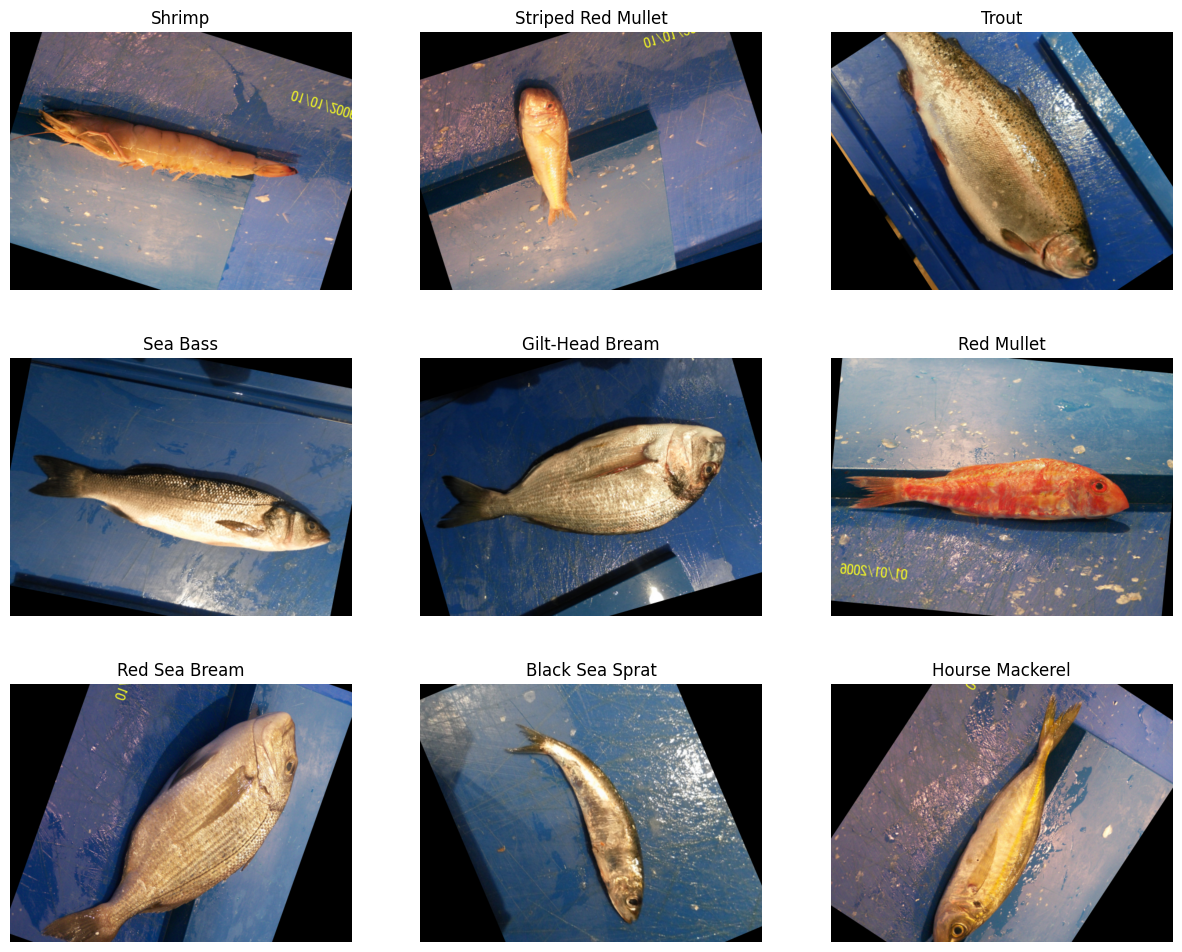

In [10]:
import matplotlib.pyplot as plt
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

# Test-Train Split

In [11]:
#Creating the test train split with shuffle
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
#Checking the shaoe of the newly obtained data
print(train_df.shape)
print(test_df.shape)

# Image Generation and Preprocessing

In [ ]:
#Using Keras Image Data Generator to preprocess our images with the model we wish to use
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

In [ ]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

In [ ]:
#Plotting images after pre-processing

fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

# Model Training and Evaluation

In [ ]:
#Importing our pretrained model : MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
#Creating our model inputs
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
# Visualize the pred_df
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

In [ ]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]

In [ ]:
pred_df.path[1604]

In [ ]:
# Which image was it?
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[1604]))
title1 = pred_df.path[1604].split('/')[-2]
title2 = pred_df.path[1604].split('/')[-1]
title3 = pred_df.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

In [ ]:
#Checking the accuracy score and creating a Confusion Matrix
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [ ]:
#Generating the Classification Report for in-depth analysis
print(classification_report(pred_df['label'],pred_df['pred']))